In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, mean_absolute_error, balanced_accuracy_score
from scipy.stats import spearmanr
#Quick function to replace the native TDC one for tox data
def evaluate_many(predictions_list):
    metric = []
    for x in predictions_list:
        for k,v in x.items():
            metric.append(average_precision_score(tox_data[k]['test'].Y, v))
    return {k:sum(metric)/float(len(metric))}
def evaluate_aupr(true,pred):
    return average_precision_score(true,pred)
def evaluate_auroc(true,pred):
    return roc_auc_score(true,pred)
def evaluate_ba(true,pred):
    return balanced_accuracy_score(true,pred)
def evaluate_mae(true,pred):
    return mean_absolute_error(true,pred)
def evaluate_spearman(true,pred):
    return spearmanr(true,pred)

In [ ]:
from tqdm import tqdm
import catboost as cb

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate

df = pd.DataFrame.from_dict(metrics)#, orient='index')
df.spearman = df['spearman'].apply(lambda x: x.statistic if not isinstance(x, float) else x)
# Generate HTML table string using tabulate
html_table = tabulate(df[['mae','spearman']].dropna(), headers='keys', tablefmt="github")#, tablefmt='html')
print(html_table)
html_table = tabulate(df[['aupr','auroc','balacc','optimal_th']].dropna(), headers='keys', tablefmt="github")#, tablefmt='html')
print(html_table)
df.to_csv('data/metrics.csv')

In [ ]:
#Get the chemicals to predict for each phase and refactor the dataframe to run inference
import pandas as pd
df_d={}
for k in ['passed_phase_1','passed_phase_2','passed_phase_3']:
    df_d[k] = pd.read_csv(f'./alladmet/NB_Pred_data_{k}.csv')
df_inf_d={}
for k in df_d:
    df_inf_d[k]=pd.DataFrame()
    df_inf_d[k]['Drug_ID'] = df_d[k].smiles.unique()
    df_inf_d[k]['Drug'] = df_d[k].smiles.unique()
    df_inf_d[k]['Y'] = 0

In [ ]:
# Infer
from collections import defaultdict
from maplight_gnn import get_fingerprints
import os
benchmark_config = {
    'caco2_wang': ('regression', False),
    'bioavailability_ma': ('binary', False),
    'lipophilicity_astrazeneca': ('regression', False),
    'solubility_aqsoldb': ('regression', False),
    'hia_hou': ('binary', False),
    'pgp_broccatelli': ('binary', False),
    'bbb_martins': ('binary', False),
    'ppbr_az': ('regression', False),
    'vdss_lombardo': ('regression', True),
    'cyp2c9_veith': ('binary', False),
    'cyp2d6_veith': ('binary', False),
    'cyp3a4_veith': ('binary', False),
    'cyp2c9_substrate_carbonmangels': ('binary', False),
    'cyp2d6_substrate_carbonmangels': ('binary', False),
    'cyp3a4_substrate_carbonmangels': ('binary', False),
    'half_life_obach': ('regression', True),
    'clearance_hepatocyte_az': ('regression', True),
    'clearance_microsome_az': ('regression', True),
    'ld50_zhu': ('regression', False),
    'herg': ('binary', False),
    'ames': ('binary', False),
    'dili': ('binary', False)
}
predictions = defaultdict(dict)
for k,v in df_inf_d.items():
    print(k)
    test = v
    seed = 5
    X_test = get_fingerprints(test['Drug'])
    for name,admet_benchmark in benchmark_config.items():
        task = admet_benchmark[0]
        print(name)
        params = {
                'random_strength': 2, 
                'random_seed': seed,
                'verbose': 0,
            }
        if task == 'regression':
            params['loss_function'] = 'MAE'            
            model = cb.CatBoostRegressor(**params)
            model.load_model(os.path.join('saved_weights',f"{name}"))
            y_pred_test = model.predict(X_test)
            print(y_pred_test)
        elif task == 'binary':
            params['loss_function'] = 'Logloss'
            model = cb.CatBoostClassifier(**params)
            model.load_model(os.path.join('saved_weights',f"{name}"))
            y_pred_test = model.predict_proba(X_test)[:, 1]
        predictions[k][name] = y_pred_test

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False).fit(X)
ohe.transform()

# New data factoring

In [173]:
df=pd.read_csv('data/clinical_trials/therapeutic_areas_clinical_trials_with_synthetic_negatives.csv')
print(df.describe())
df['passed_phase_1']=df['passed_phase_1'].astype(str)

       therapeutic_area      chembl             smiles passed_phase_1  \
count             33347       33347              33347          33347   
unique               84        2901               2901              2   
top         EFO_0000651  CHEMBL1431  CN(C)C(=N)NC(=N)N           True   
freq               1138         133                133          31022   

       passed_phase_2 passed_phase_3  
count           33347          33347  
unique              4              4  
top             False          False  
freq            18442          19413  


<Axes: >

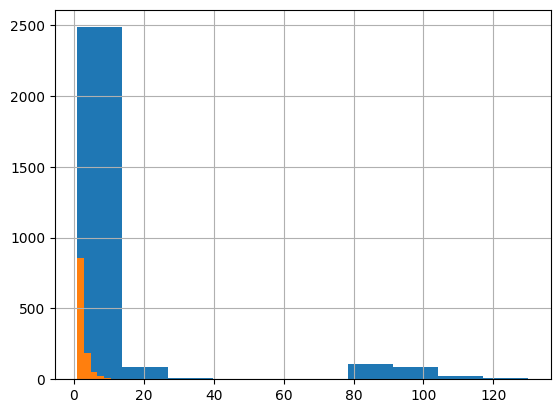

In [166]:
df[df.passed_phase_1=='True'].smiles.value_counts().hist()
df[df.passed_phase_1=='False'].smiles.value_counts().hist()

In [180]:
df=df.sample(frac=1).sort_values(by='smiles')

In [181]:
df_d = {k: df[['therapeutic_area','smiles',k]][df[k].isin(['True','False'])] for k in ['passed_phase_1','passed_phase_2','passed_phase_3']}
df_xx_d = {k:get_fingerprints(df_d[k].smiles) for k in df_d.keys()}

In [182]:
df_xx_d = {k:pd.DataFrame(df_xx_d[k]) for k in df_xx_d.keys()}
for k,v in df_xx_d.items():
    v.to_csv(f'{k}_fingerprints.csv')
#df_xx_d = {k:pd.read_csv(f'{k}_fingerprints.csv') for k in df_d.keys()}

In [183]:
df_xx_d = {k:v.fillna(0).assign(therapeutic_area=df_d[k].therapeutic_area) for k,v in df_xx_d.items()}

In [184]:
for k,v in df_xx_d.items():
    df_xx_d[k]=v.fillna('unknown')

In [185]:
for v in df_xx_d.values():
    print((v==b'unknown').any().sum())
for v in df_yy_d.values():
    print((v=='unknown').any().sum())

0
0
0
0
0
0


In [186]:
df_yy_d = {k: df_d[k][k].map({'True':1,'False':0}).astype(int) for k in df_d.keys()}

In [187]:
for v in df_yy_d.values():
    print(v.describe())

count    33347.000000
mean         0.930279
std          0.254681
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: passed_phase_1, dtype: float64
count    27774.000000
mean         0.335998
std          0.472347
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: passed_phase_2, dtype: float64
count    24666.000000
mean         0.212965
std          0.409412
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: passed_phase_3, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import catboost as cb
import matplotlib.pyplot as plt
for k in df_d.keys():
    print(f"-----------------")
    print(k)
    print(f"-----------------")

    kf = KFold(n_splits=5)#, random_state=42, shuffle=False)
    scores = defaultdict(list)
    for i, (train_index, test_index) in enumerate(kf.split(df_xx_d[k])):
        #print(f"Fold {i}:")
        #df_xx_d[k].columns = df_xx_d[k].columns.astype(str)
        X_train, X_test, y_train, y_test = (df_xx_d[k].iloc[train_index],
                                            df_xx_d[k].iloc[test_index],
                                            df_yy_d[k].iloc[train_index],
                                            df_yy_d[k].iloc[test_index])
        #X_train, X_test, y_train, y_test = train_test_split(df_xx_d[k], df_yy_d[k], test_size=0.1, random_state=r)
        #print(y_train.sum()/len(y_train))
        #gnb = GaussianNB()
        #s_weights = [c_weight[k] if x == 1 else 1.0 for x in y_train ]
        #gnb = LogisticRegression()
        #y_pred = gnb.fit(X_train, y_train, sample_weight=s_weights).predict(X_test)
        gnb = cb.CatBoostClassifier(loss_function = 'Logloss', 
                                    simple_ctr='Counter',
                                    combinations_ctr='Counter',
                                    cat_features=['therapeutic_area'],
                                    #class_weights=[1.0,c_weight[k]],
                                    verbose=0)
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        """
        print('---------')
        print("Number of mislabeled points out of a total %d points : %d"
              % (X_test.shape[0], (y_test != y_pred).sum()))
        print(f"{gnb.score(X_test,y_test)=}")
        print(f"{average_precision_score(y_test, y_pred)=}")
        print(f"{roc_auc_score(y_test,y_pred)=}")
        print(f"{f1_score(y_test,y_pred)=}")
        """
        scores['loss'].append(gnb.score(X_test,y_test))
        scores['ap'].append(average_precision_score(y_test, y_pred))
        scores['roc'].append(roc_auc_score(y_test,y_pred))
        scores['f1'].append(f1_score(y_test,y_pred))
        # = plt.subplots()
        #ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test)
        #plt.show()
    for k,v in scores.items():
        print(f"{k}:{sum(v)/len(v)}")

-----------------
passed_phase_1
-----------------


# Old data tests

In [ ]:
#Load data with smiles and passed or not
import pandas as pd
df_d={}
for k in ['passed_phase_1','passed_phase_2','passed_phase_3']:
    df_d[k] = pd.read_csv(f'./alladmet/NB_Pred_data_{k}.csv')
df_d

In [ ]:
X = defaultdict(lambda: pd.DataFrame())
for k,v in predictions.items():
    for name,arr in v.items():
        X[k][name] = arr
predictions

In [ ]:
X = {k:pd.concat([df_inf_d[k],v],axis=1).rename(columns={'Drug':'smiles'}) for k,v in X.items()}
for k,v in X.items():
    v.to_csv(f'predictions_{k}.csv')

In [ ]:
X

In [ ]:
#X=X.rename(columns={'Drug':'smiles'}) #.drop(columns='Y')
df_d_ = {k:v.join(X[k].set_index('smiles'), on='smiles') for k,v in df_d.items()} #.drop(columns=['Drug_ID','Y'])
for k in df_d_:
    #df_d[k]['Y'] = (df_d[k].y == 'Failed').astype(int)
    #df_d_[k]
    df_d_[k]=df_d_[k][df_d_[k].y != "Not tested"]
    df_d_[k]['Y'] = df_d_[k]['y'].isin([False,'False']).astype(int)
    #df_d_[k].rename(columns={'y':'Y'})
#df

In [ ]:
#NOT NEEDED WITH CATBOOST!!! IT OHEs itself
from sklearn.preprocessing import OneHotEncoder
# data is a Pandas DataFrame
data={}
for k,v in df_d_.items():
    jobs_encoder = OneHotEncoder(sparse=False)
    jobs_encoder.fit(v['indication'].unique().reshape(-1, 1))
    transformed = jobs_encoder.transform(v['indication'].to_numpy().reshape(-1,1))
    #Create a Pandas DataFrame of the hot encoded column
    ohe_df = pd.DataFrame(transformed, columns=jobs_encoder.get_feature_names_out())
    #concat with original data
    print(v.shape)
    print(ohe_df.shape)
    data[k] = pd.concat([v.reset_index(), ohe_df], axis=1)#.drop(columns=['smiles', 'Unnamed: 0',k, 'indication','Drug_ID'])
    #data.to_csv('all_w_ohe.csv')

In [ ]:
#data['passed_phase_1'].columns

In [ ]:
X, y = data.drop(columns='Y').to_numpy(), data.Y.to_numpy()

In [ ]:
df_in = df_d_
drop = ['Unnamed: 0', 'Drug_ID','y']
#df_in = data
#drop = ['Unnamed: 0', 'Drug_ID','y','index','indication','smiles']
df_in = {k:v.sample(frac=1).reset_index(drop=True) for k,v in df_in.items()}
df_xy_d = {k: v.drop(columns=drop) for k,v in df_in.items()}
df_xx_d = {k: v.drop(columns='Y') for k,v in df_xy_d.items()}
df_yy_d = {k: v.Y for k,v in df_xy_d.items()}
#X_test_d = {k: get_fingerprints(v['smiles']) for k,v in df_xx_d.items()}

In [ ]:
df_xx_d = {k: pd.concat([v.reset_index(drop=True),pd.DataFrame(X_test_d[k])],axis=1).drop('smiles',axis=1) for k,v in df_xx_d.items()}
#df_xx_d={k:v.drop(columns='index') for k,v in df_xx_d.items()}

In [ ]:
df_xx_d

In [ ]:
c_weight = {k: len(v)/sum(v) for k,v in df_yy_d.items()}
c_weight

In [ ]:
df_xx_d = {k:v.drop(columns=v.columns[1:]) for k,v in df_xx_d.items()}

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
for k in df_d_.keys():
    print(f"-----------------")
    print(k)
    print(f"-----------------")

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = defaultdict(list)
    for i, (train_index, test_index) in enumerate(kf.split(df_xx_d[k])):
        #print(f"Fold {i}:")
        #df_xx_d[k].columns = df_xx_d[k].columns.astype(str)
        X_train, X_test, y_train, y_test = (df_xx_d[k].iloc[train_index],
                                            df_xx_d[k].iloc[test_index],
                                            df_yy_d[k].iloc[train_index],
                                            df_yy_d[k].iloc[test_index])
        #X_train, X_test, y_train, y_test = train_test_split(df_xx_d[k], df_yy_d[k], test_size=0.1, random_state=r)
        #print(y_train.sum()/len(y_train))
        #gnb = GaussianNB()
        #s_weights = [c_weight[k] if x == 1 else 1.0 for x in y_train ]
        #gnb = LogisticRegression()
        #y_pred = gnb.fit(X_train, y_train, sample_weight=s_weights).predict(X_test)
        gnb = cb.CatBoostClassifier(loss_function = 'Logloss', 
                                    simple_ctr='Counter',
                                    combinations_ctr='Counter',
                                    cat_features=['indication'],
                                    class_weights=[1.0,c_weight[k]],
                                    verbose=0)
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        """
        print('---------')
        print("Number of mislabeled points out of a total %d points : %d"
              % (X_test.shape[0], (y_test != y_pred).sum()))
        print(f"{gnb.score(X_test,y_test)=}")
        print(f"{average_precision_score(y_test, y_pred)=}")
        print(f"{roc_auc_score(y_test,y_pred)=}")
        print(f"{f1_score(y_test,y_pred)=}")
        """
        scores['loss'].append(gnb.score(X_test,y_test))
        scores['ap'].append(average_precision_score(y_test, y_pred))
        scores['roc'].append(roc_auc_score(y_test,y_pred))
        scores['f1'].append(f1_score(y_test,y_pred))
        # = plt.subplots()
        #ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test)
        #plt.show()
    for k,v in scores.items():
        print(f"{k}:{sum(v)/len(v)}")

In [ ]:
df_xx_d = {k:v.reset_index(drop=True) for k,v in df_xx_d.items()}

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

parameters = {'depth' : [6,7,8,12],
              'learning_rate' : [0.1,.15,.2],
              'iterations'    : [80,90,100,120,140],
              }
grid = {}
for k,v in df_xx_d.items():
    model = cb.CatBoostClassifier(loss_function = 'Logloss', 
                            simple_ctr='Counter',
                            combinations_ctr='Counter',
                            cat_features=['indication'],
                            class_weights=[1.0,c_weight[k]],
                            verbose=0)
    grid[k] = GridSearchCV(estimator=model, 
                        param_grid = parameters, 
                        cv = 3, 
                        n_jobs=-1, 
                        verbose=3,
                       #scoring='f1'
                        scoring=['f1','balanced_accuracy','average_precision','roc_auc'],
                        refit=False
                       )
    grid[k].fit(df_xx_d[k],df_yy_d[k])

In [ ]:
#!conda run -n maplight pip install tabulate
from tabulate import tabulate
from collections import defaultdict
data = defaultdict(list)
phases = ['passed_phase_1','passed_phase_2','passed_phase_3']
mets = ['mean_test_f1','mean_test_average_precision','mean_test_roc_auc','mean_test_balanced_accuracy']
data['metric']=mets
for j in phases:
    for k in mets:
        data[j].append(pd.DataFrame(grid[j].cv_results_).sort_values(k,ascending=False)[k].head(1).values)
print(data)
tabulate(data,tablefmt='html', headers = data.keys())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=r)
#X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=r)
model = GaussianNB()
#s_weights = [c_weight if x == 1 else 1.0 for x in y_train ]


parameters = {
    'var_smoothing': np.logspace(1,-3, num=100)
}

grid = GridSearchCV(estimator=model, 
                    param_grid = parameters, 
                    cv = 5, 
                    n_jobs=-1, 
                    verbose=3,
                   scoring='f1')
grid.fit(X_train,y_train)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from fastFM import sgd
fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
                          l2_reg_V=0, rank=2, step_size=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=r)
#X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=r)
#model = GaussianNB()
#s_weights = [c_weight if x == 1 else 1.0 for x in y_train ]
y_labels = np.ones_like(y_train)
y_labels[y_train == 0 ] = -1
y_train=y_labels
fm.fit(X_train, y_train)
y_pred = fm.predict(X_test)

In [ ]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=5)
clf = GaussianNB()
#clf = LogisticRegression()
print(f"roc: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='roc_auc').mean()}")
print(f"f1: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='f1').mean()}")
print(f"ap: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='average_precision').mean()}")


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=5)
#clf = GaussianNB()
clf = LogisticRegression()
print(f"roc: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='roc_auc').mean()}")
print(f"f1: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='f1').mean()}")
print(f"ap: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='average_precision').mean()}")

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

imps_test = permutation_importance(gnb, X_test, y_test, n_repeats=30)
print(imps_test.importances_mean)
imps_train = permutation_importance(gnb, X_train, y_train, n_repeats=30)
print(imps_train.importances_mean)

In [ ]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=100, random_state=42, scoring='f1')#, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (5,15))
_ = plot_permutation_importance(gnb, X_test, y_test, ax)
#print(print(f"Baseline accuracy on test data: {gnb.score(X_train, y_train):.2}"))

In [ ]:
fig, ax = plt.subplots(figsize = (5, 15))
_ = plot_permutation_importance(gnb, X_train, y_train, ax)
ax.set_xlabel(r'$\longleftarrow$ Importance')